In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
!pip install --quiet dtaidistance

import logging

logging.disable(logging.CRITICAL)
plt.rcParams["figure.figsize"] = (20,8)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 38.4 MB/s eta 0:00:00


In [6]:
from google.colab import files
import io
import pandas as pd

# 1) Upload any files
print("Upload your full_features CSV and/or Excel:")
uploaded = files.upload()

# 2) Load the ones that have “full_features” in their filename
df_csv = None
df_xlsx = None

for fname, content in uploaded.items():
    lname = fname.lower()
    if "full_features" in lname:
        if lname.endswith(".csv"):
            df_csv = pd.read_csv(
                io.BytesIO(content),
                index_col=0,
                parse_dates=True
            )
            print(f"Loaded CSV into df_csv from {fname}")
        elif lname.endswith((".xls", ".xlsx")):
            df_xlsx = pd.read_excel(
                io.BytesIO(content),
                sheet_name=0,
                index_col=0,
                parse_dates=True
            )
            print(f"Loaded Excel into df_xlsx from {fname}")

# 3) Now df_csv and/or df_xlsx hold your DataFrame(s)
# Example check:
if df_csv is not None:
    print("CSV shape:", df_csv.shape)
    display(df_csv.head())
if df_xlsx is not None:
    print("Excel shape:", df_xlsx.shape)
    display(df_xlsx.head())



Upload your full_features CSV and/or Excel:


Saving VAF_hourly_full_features (1).csv to VAF_hourly_full_features (1).csv
Loaded CSV into df_csv from VAF_hourly_full_features (1).csv
CSV shape: (5646, 74)


,Load,hour,Day_of_week,Day_of_year,month,year,week_of_year,season,is_weekend,hour_sin,...,Exogenous_5_shifted_48,Exogenous_3_shifted_24,Exogenous_4_shifted_24,Exogenous_5_shifted_24,Relation_Hour_Weekday,shift_1,shift_2,temperature,temperature_lag48,temperature_lag54
datetime,,,,,,,,,,,,,,,,,,,,,
2024-06-13 23:00:00,984.0,23,3,165,6,2024,24,0,0,-0.258819,...,0.0,0.0,0.0,0.0,1,0,1,NaN,NaN,NaN
2024-06-14 00:00:00,1110.0,0,4,166,6,2024,24,0,0,0.000000,...,0.0,0.0,0.0,0.0,1,0,1,NaN,NaN,NaN
2024-06-14 01:00:00,1139.0,1,4,166,6,2024,24,0,0,0.258819,...,0.0,0.0,0.0,0.0,1,0,1,NaN,NaN,NaN
2024-06-14 02:00:00,928.0,2,4,166,6,2024,24,0,0,0.500000,...,0.0,0.0,0.0,0.0,1,0,1,NaN,NaN,NaN
2024-06-14 03:00:00,678.0,3,4,166,6,2024,24,0,0,0.707107,...,0.0,0.0,0.0,0.0,0,0,1,NaN,NaN,NaN


In [8]:
# df_cvs_VAF = df_csv.copy()
df_cvs_VAF.tail()

,Load,hour,Day_of_week,Day_of_year,month,year,week_of_year,season,is_weekend,hour_sin,...,Exogenous_5_shifted_48,Exogenous_3_shifted_24,Exogenous_4_shifted_24,Exogenous_5_shifted_24,Relation_Hour_Weekday,shift_1,shift_2,temperature,temperature_lag48,temperature_lag54
datetime,,,,,,,,,,,,,,,,,,,,,
2025-02-04 00:00:00,1273.0,0,1,35,2,2025,6,2,0,0.000000,...,0.0,0.0,0.0,0.0,1,0,1,NaN,NaN,NaN
2025-02-04 01:00:00,1295.0,1,1,35,2,2025,6,2,0,0.258819,...,0.0,0.0,0.0,0.0,1,0,1,NaN,NaN,NaN
2025-02-04 02:00:00,1182.0,2,1,35,2,2025,6,2,0,0.500000,...,0.0,0.0,0.0,0.0,1,0,1,NaN,NaN,NaN
2025-02-04 03:00:00,1204.0,3,1,35,2,2025,6,2,0,0.707107,...,0.0,0.0,0.0,0.0,1,0,1,NaN,NaN,NaN
2025-02-04 04:00:00,1480.0,4,1,35,2,2025,6,2,0,0.866025,...,0.0,0.0,0.0,0.0,1,0,1,NaN,NaN,NaN


In [13]:
# df_cvs_VEL =  df_csv.copy()
df_cvs_VEL.tail()

,Load,hour,Day_of_week,Day_of_year,month,year,week_of_year,season,is_weekend,hour_sin,...,Exogenous_5_shifted_48,Exogenous_3_shifted_24,Exogenous_4_shifted_24,Exogenous_5_shifted_24,Relation_Hour_Weekday,shift_1,shift_2,temperature,temperature_lag48,temperature_lag54
datetime,,,,,,,,,,,,,,,,,,,,,
2025-02-04 00:00:00,47.0,0,1,35,2,2025,6,2,0,0.000000,...,1.0,1.0,0.0,1.0,1,0,1,NaN,NaN,NaN
2025-02-04 01:00:00,47.0,1,1,35,2,2025,6,2,0,0.258819,...,1.0,1.0,0.0,1.0,1,0,1,NaN,NaN,NaN
2025-02-04 02:00:00,48.0,2,1,35,2,2025,6,2,0,0.500000,...,1.0,1.0,0.0,1.0,1,0,1,NaN,NaN,NaN
2025-02-04 03:00:00,68.0,3,1,35,2,2025,6,2,0,0.707107,...,1.0,1.0,0.0,1.0,1,0,1,NaN,NaN,NaN
2025-02-04 04:00:00,138.0,4,1,35,2,2025,6,2,0,0.866025,...,1.0,0.0,0.0,1.0,0,0,1,NaN,NaN,NaN


In [10]:
# df_cvs_VPC = df_csv.copy()
df_cvs_VPC.tail()

,Load,hour,Day_of_week,Day_of_year,month,year,week_of_year,season,is_weekend,hour_sin,...,Exogenous_5_shifted_48,Exogenous_3_shifted_24,Exogenous_4_shifted_24,Exogenous_5_shifted_24,Relation_Hour_Weekday,shift_1,shift_2,temperature,temperature_lag48,temperature_lag54
datetime,,,,,,,,,,,,,,,,,,,,,
2025-02-04 00:00:00,58.0,0,1,35,2,2025,6,2,0,0.000000,...,1.0,0.0,0.0,0.0,2,0,1,NaN,NaN,NaN
2025-02-04 01:00:00,46.0,1,1,35,2,2025,6,2,0,0.258819,...,1.0,0.0,0.0,0.0,2,0,1,NaN,NaN,NaN
2025-02-04 02:00:00,42.0,2,1,35,2,2025,6,2,0,0.500000,...,1.0,0.0,1.0,1.0,2,0,1,NaN,NaN,NaN
2025-02-04 03:00:00,46.0,3,1,35,2,2025,6,2,0,0.707107,...,1.0,0.0,1.0,1.0,0,0,1,NaN,NaN,NaN
2025-02-04 04:00:00,49.0,4,1,35,2,2025,6,2,0,0.866025,...,1.0,0.0,1.0,1.0,1,0,1,NaN,NaN,NaN


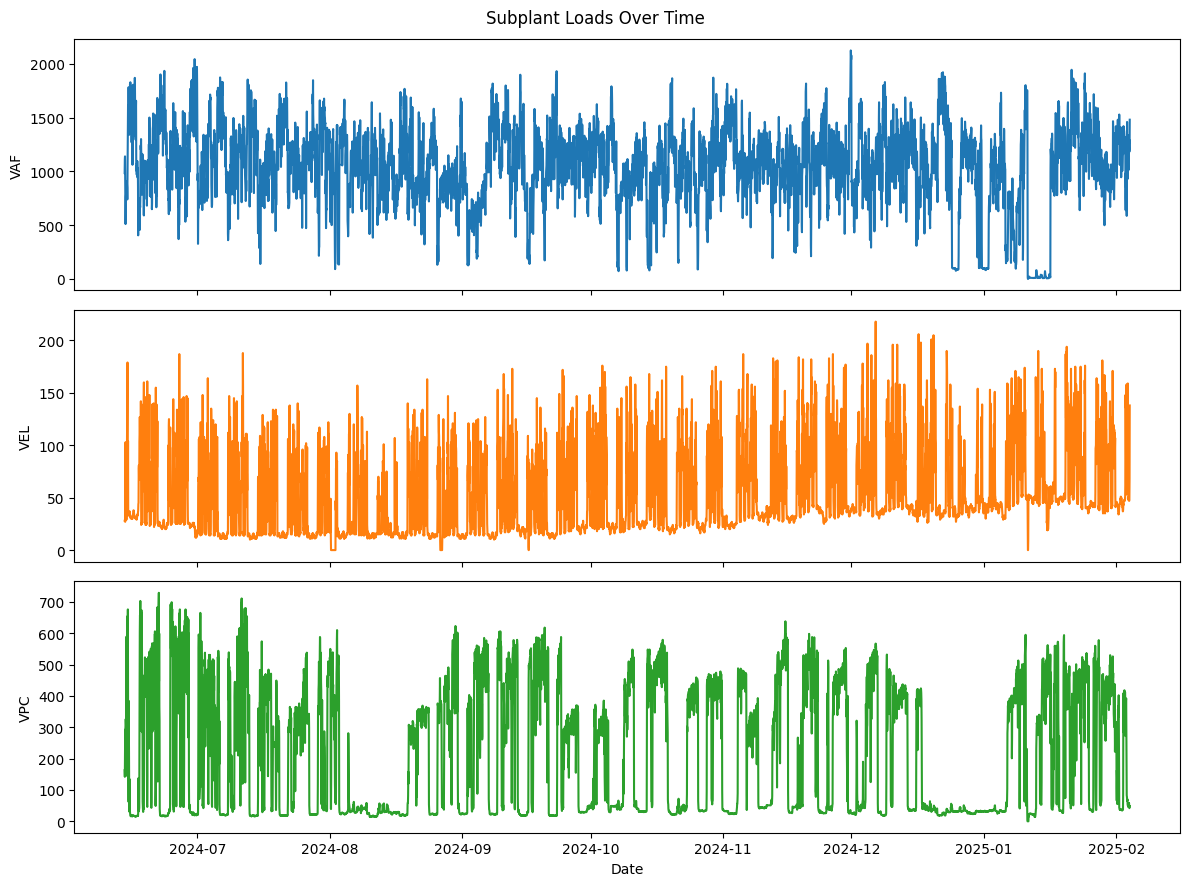

In [14]:
fig, axs = plt.subplots(3, 1, figsize=(12, 9), sharex=True)

axs[0].plot(df_cvs_VAF.index, df_cvs_VAF['Load'], label='VAF', color='tab:blue')
axs[0].set_ylabel('VAF')

axs[1].plot(df_cvs_VEL.index, df_cvs_VEL['Load'], label='VEL', color='tab:orange')
axs[1].set_ylabel('VEL')

axs[2].plot(df_cvs_VPC.index, df_cvs_VPC['Load'], label='VPC', color='tab:green')
axs[2].set_ylabel('VPC')
axs[2].set_xlabel('Date')

fig.suptitle('Subplant Loads Over Time')
plt.tight_layout()
plt.show()


In [15]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create subplot with 3 rows
fig = make_subplots(rows=3, cols=1, shared_xaxes=True,
                    subplot_titles=('VAF', 'VEL', 'VPC'))

# Add traces
fig.add_trace(go.Scatter(x=df_cvs_VAF.index, y=df_cvs_VAF['Load'],
                         mode='lines', name='VAF', line=dict(color='blue')),
              row=1, col=1)

fig.add_trace(go.Scatter(x=df_cvs_VEL.index, y=df_cvs_VEL['Load'],
                         mode='lines', name='VEL', line=dict(color='orange')),
              row=2, col=1)

fig.add_trace(go.Scatter(x=df_cvs_VPC.index, y=df_cvs_VPC['Load'],
                         mode='lines', name='VPC', line=dict(color='green')),
              row=3, col=1)

# Update layout
fig.update_layout(height=800, width=1000, title_text="Subplant Loads Over Time",
                  showlegend=False)

# Add axis labels
fig.update_xaxes(title_text="Date", row=3, col=1)
fig.update_yaxes(title_text="Load", row=1, col=1)
fig.update_yaxes(title_text="Load", row=2, col=1)
fig.update_yaxes(title_text="Load", row=3, col=1)

fig.show()


In [16]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Cut-off dates
train_end = pd.to_datetime("2024-10-20")
val_end = pd.to_datetime("2024-11-12")
test_end = pd.to_datetime("2024-12-24 23:00")

# Make copies to preserve original data
df_vaf_cut = df_cvs_VAF.copy()
df_vel_cut = df_cvs_VEL.copy()
df_vpc_cut = df_cvs_VPC.copy()

# Truncate copies
df_vaf_cut = df_vaf_cut[df_vaf_cut.index <= test_end]
df_vel_cut = df_vel_cut[df_vel_cut.index <= test_end]
df_vpc_cut = df_vpc_cut[df_vpc_cut.index <= test_end]

# Total number of samples
total = len(df_vaf_cut)
n_train = len(df_vaf_cut[df_vaf_cut.index < train_end])
n_val = len(df_vaf_cut[(df_vaf_cut.index >= train_end) & (df_vaf_cut.index < val_end)])
n_test = len(df_vaf_cut[df_vaf_cut.index >= val_end])

p_train = 100 * n_train / total
p_val = 100 * n_val / total
p_test = 100 * n_test / total

# Create subplots
fig = make_subplots(rows=3, cols=1, shared_xaxes=True,
    subplot_titles=[
        f"VAF (Train={p_train:.1f}%, Val={p_val:.1f}%, Test={p_test:.1f}%)",
        f"VEL (Train={p_train:.1f}%, Val={p_val:.1f}%, Test={p_test:.1f}%)",
        f"VPC (Train={p_train:.1f}%, Val={p_val:.1f}%, Test={p_test:.1f}%)"
    ]
)

# Helper to add colored segments
def add_segments(df, row):
    df_train = df[df.index < train_end]
    df_val = df[(df.index >= train_end) & (df.index < val_end)]
    df_test = df[df.index >= val_end]

    fig.add_trace(go.Scatter(x=df_train.index, y=df_train["Load"], mode="lines",
                             line=dict(color="green"), name="Train"), row=row, col=1)
    fig.add_trace(go.Scatter(x=df_val.index, y=df_val["Load"], mode="lines",
                             line=dict(color="blue"), name="Validation"), row=row, col=1)
    fig.add_trace(go.Scatter(x=df_test.index, y=df_test["Load"], mode="lines",
                             line=dict(color="red"), name="Test"), row=row, col=1)

# Add all 3
add_segments(df_vaf_cut, 1)
add_segments(df_vel_cut, 2)
add_segments(df_vpc_cut, 3)

def print_info(df):
    df_train = df[df.index < train_end]
    df_val = df[(df.index >= train_end) & (df.index < val_end)]
    df_test = df[df.index >= val_end]

    print("Train mean:", df_train['Load'].mean(), " | std:", df_train['Load'].std())
    print("Test  mean:", df_test['Load'].mean(), " | std:", df_test['Load'].std())


# Layout
fig.update_layout(height=850, width=1000,
    title="Subplant Loads Over Time by Dataset Split",
    showlegend=True
)

fig.update_xaxes(title_text="Date", row=3, col=1)
for r in range(1, 4):
    fig.update_yaxes(title_text="Load", row=r, col=1)

fig.show()


print_info(df_vel_cut)



Train mean: 43.07614708753661  | std: 37.467425876578424
Test  mean: 66.17102713178295  | std: 41.42828358274405


In [17]:
def mean_absolute_percentage_error(actual, pred):
    actual = np.array(actual)
    pred   = np.array(pred)
    # Calculate MAPE (%) – add a small epsilon to avoid division by zero if needed
    return np.mean(np.abs((actual - pred) / (actual + 1e-8))) * 100

def directional_mean_accuracy(actual, pred):
    actual = np.array(actual)
    pred   = np.array(pred)
    # Calculate the sign of changes for actual and predicted
    actual_direction = np.sign(actual[1:] - actual[:-1])
    pred_direction   = np.sign(pred[1:] - pred[:-1])
    # Compare directions and compute accuracy as a percentage
    correct_direction = (actual_direction == pred_direction)
    return np.mean(correct_direction) * 100


LSTM

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.1647 - val_loss: 0.0310
Epoch 2/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0466 - val_loss: 0.0253
Epoch 3/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0420 - val_loss: 0.0238
Epoch 4/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0391 - val_loss: 0.0221
Epoch 5/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0376 - val_loss: 0.0220
Epoch 6/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0365 - val_loss: 0.0215
Epoch 7/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0345 - val_loss: 0.0212
Epoch 8/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0347 - val_loss: 0.0210
Epoch 9/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0343 - val_loss: 0.0237
Epoch 10/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0336 - val_loss: 0.0214
Epoch 11/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0302 - val_loss: 0.0203
Epoch 12/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0288 - val_l

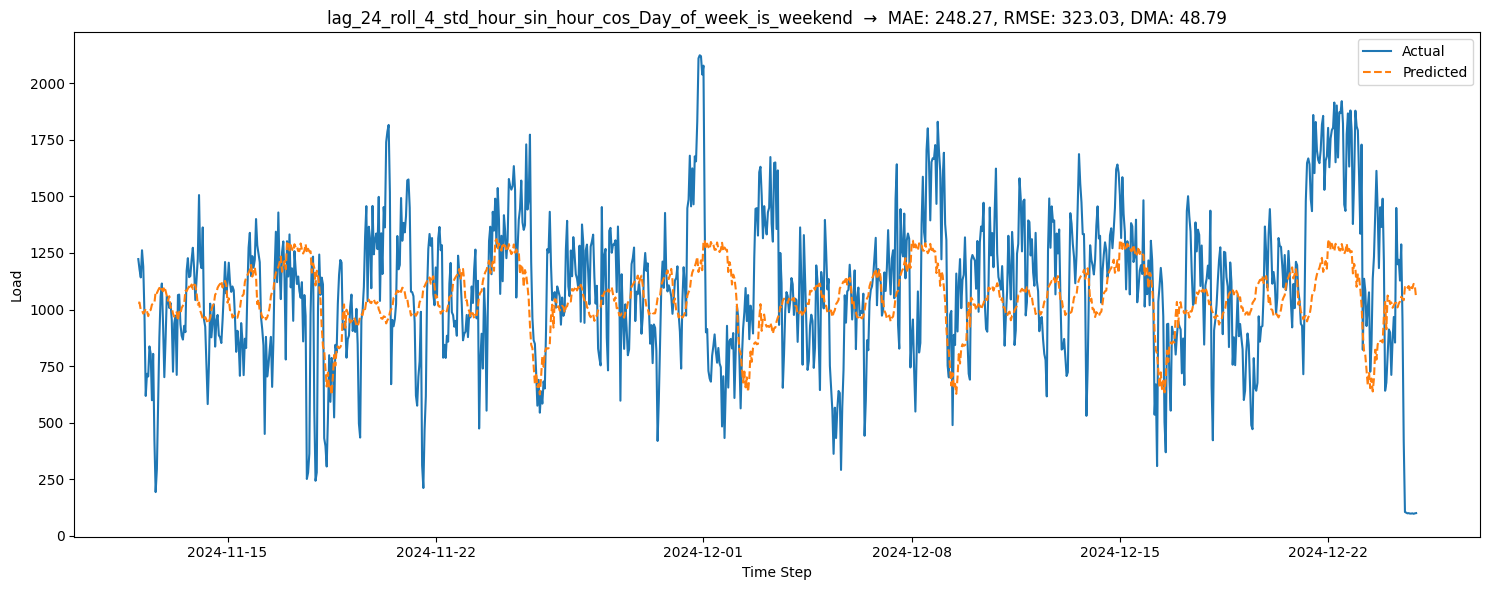

✔ [lag_24_roll_4_std_hour_sin_hour_cos_Day_of_week_is_weekend] saved model + plot  →  MAE_val: 240.549, RMSE_val: 310.381,  MAE_test: 248.271, RMSE_test: 323.029, DMA: 48.79, DTW: 7910.80

All results:
                                            features    MAE_val    RMSE_val  \
0  [lag_24, roll_4_std, hour_sin, hour_cos, Day_o...  240.54889  310.380811   

     MAE_test   RMSE_test        DMA          DTW  
0  248.271212  323.028785  48.787585  7910.795927  

Best combo: ['lag_24', 'roll_4_std', 'hour_sin', 'hour_cos', 'Day_of_week', 'is_weekend']  →  MAE_val: 240.549
hour_sin   -0.000084
dtype: float64 hour_sin    0.707122
dtype: float64
hour_cos    0.000314
dtype: float64 hour_cos    0.707321
dtype: float64
day_sin   -0.010862
dtype: float64 day_sin    0.707833
dtype: float64
day_cos   -0.009068
dtype: float64 day_cos    0.706469
dtype: float64
is_weekend    0.288968
dtype: float64 is_weekend    0.453357
dtype: float64
low_load_shifted_24    0.045233
dtype: float64 low_load_shifted

In [47]:
import os
import joblib
import math
import numpy as np
import pandas as pd
from itertools import combinations
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from dtaidistance import dtw


# ── EDIT THIS TO YOUR LOCAL WIN PATH ────────────────────────────────
from google.colab import drive
drive.mount('/content/drive')

BASE_DIR  = "/content/drive/MyDrive/Thesis AI - vaheeden/saved_models"
MODELS_DIR = os.path.join(BASE_DIR, "models")
PLOTS_DIR  = os.path.join(BASE_DIR, "plots")
os.makedirs(PLOTS_DIR, exist_ok=True)

# ─────────────────────────────────────────────────────────────────────

os.makedirs(PLOTS_DIR, exist_ok=True)

df_csv = df_vaf_cut

# --- your create_sequences ---
def create_sequences(data, feature_cols, window_size, prediction_time):
    X, y = [], []
    for i in range(len(data) - window_size - prediction_time +1):
        X.append(data.iloc[i:i + window_size][feature_cols].values)
        y.append(data.iloc[i + window_size:i + window_size + prediction_time]['Load'].values)
    return np.array(X), np.array(y)


def create_sequences_24_hour(data,feature_cols, window_size=168, Prediction_time=24,step=1, return_times=True):
    X, y, times = [], [], []
    for i in range(0,len(data) - window_size - Prediction_time +1, step):  # Forecast next 96 steps
        X.append(data.iloc[i:i + window_size ][feature_cols].values)
        y.append(data.iloc[i + window_size:i + window_size + Prediction_time]['Load'].values)
        if return_times:
            times.append(data.index[i + window_size])   # 00:00 of day T+1
    print("Last forecast made for:", times[-1] + pd.Timedelta(hours=23))
    print("Last timestamp in dataset:", data.index[-1])

    if return_times:
        return np.array(X), np.array(y), times
    return np.array(X), np.array(y)

import plotly.graph_objects as go
import os




# --- LSTM builder ---
def build_lstm_model(window_size, n_features, prediction_time,
                     lstm_units=[64, 32], dropout=0.1):
    optimizer = Adam(learning_rate=0.0002)
    m = Sequential([
        LSTM(lstm_units[0], activation='tanh', return_sequences=True,
             input_shape=(window_size, n_features)),
        Dropout(dropout),
        LSTM(lstm_units[1], activation='tanh', return_sequences=False),
        Dropout(dropout),
        Dense(prediction_time)
    ])
    m.compile(optimizer='adam', loss='mse')
    return m


import tensorflow as tf
from tensorflow.keras.layers import (
    Input, LSTM, Dropout, Dense, Concatenate, Lambda, GlobalAveragePooling1D
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam



# 3. Define cut‑over dates
val_start  = pd.to_datetime("2024-10-20")
test_start = pd.to_datetime("2024-11-12")

# 4. Slice into train/val/test on the truncated data
train_df = df_csv.loc[: val_start - pd.Timedelta(hours=1)].copy()
val_df   = df_csv.loc[val_start : test_start - pd.Timedelta(hours=1)].copy()
test_df  = df_csv.loc[test_start :].copy()


    # --- settings ---
window_size     = 144
prediction_time = 24

test_combinations= [ [ 'lag_24',  'roll_4_std','hour_sin','hour_cos','Day_of_week','is_weekend']]

results = []

# grab the final 7 days from train+val
warmup_val = pd.concat([train_df]).iloc[-window_size:]
warmup_test = pd.concat([train_df, val_df]).iloc[-window_size:]

# build an “extended” test set that starts window_size hours *before* test_start
val_extended = pd.concat([warmup_val, val_df])
test_extended = pd.concat([warmup_test, test_df])

for combo in test_combinations:
    from tensorflow.keras import backend as K
    K.clear_session()  # resets old models
    feat_str = "_".join(combo)

    # Define groups
    features_to_scale = ['lag_24', 'lag_144', 'lag_312', 'roll_4_std', 'year','Day_of_week', 'historical_avg_direct_4']
    features_pass = ['hour_sin', 'hour_cos', 'day_sin', 'day_cos','is_weekend','low_load_shifted_24']


        # Fit scalers only on train set
    from sklearn.preprocessing import RobustScaler
    # scaler_y = RobustScaler().fit(train_df[['Load']])

        # Fit scalers only on train set
    scaler_X = MinMaxScaler(feature_range=(0, 1)).fit(train_df[features_to_scale])
    scaler_y = MinMaxScaler(feature_range=(0, 1)).fit(train_df[['Load']])


    # helper to scale any df
    def scale_df(df):
      df_s = pd.DataFrame(index=df.index)
      # Scale numeric features
      df_s[features_to_scale] = scaler_X.transform(df[features_to_scale])
      # Pass through raw cyclical/binary features
      df_s[features_pass] = df[features_pass]
      # Scale target
      df_s["Load"] = scaler_y.transform(df[["Load"]])
      return df_s

    train_s = scale_df(train_df)
    val_s   = scale_df(val_df)
    test_s  = scale_df(test_extended)

    # 2) sequences
    X_tr, y_tr = create_sequences(train_s, combo, window_size, prediction_time)
    X_val, y_val = create_sequences(val_s, combo, window_size, prediction_time)
    X_te, y_te = create_sequences(test_s, combo, window_size, prediction_time)


       # 3) build & train
    model = build_lstm_model(window_size, len(combo), prediction_time)
    # model = build_lstm_with_onoff(window_size, len(combo), prediction_time)
    es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model.fit(
        X_tr, y_tr,
        validation_data=(X_val, y_val),
        epochs=50, batch_size=32,
        callbacks=[es],
        shuffle=False
    )

    # 4) evaluate
    y_pred_s   = model.predict(X_te)
    y_te_inv   = scaler_y.inverse_transform(y_te)
    y_pred_inv = scaler_y.inverse_transform(y_pred_s)

    mae  = mean_absolute_error(y_te_inv.flatten(), y_pred_inv.flatten())
    rmse = math.sqrt(mean_squared_error(y_te_inv.flatten(), y_pred_inv.flatten()))

    # 5) save model & scalers
    model_path    = os.path.join(MODELS_DIR,     f"lstm_{feat_str}_1fout.h5")
    scalerX_path  = os.path.join(MODELS_DIR,     f"scalerX_{feat_str}_1fout.pkl")
    scalerY_path  = os.path.join(MODELS_DIR,     f"scalery_{feat_str}_1fout.pkl")

    model.save(model_path)
    joblib.dump(scaler_X, scalerX_path)
    joblib.dump(scaler_y, scalerY_path)


    # 24 hour plot (more correct)
    X_test, y_test, t0_list = create_sequences_24_hour(test_s, combo, window_size, prediction_time, step=24, return_times=True)
    y_pred_scaled_2 = model.predict(X_test)
    y_pred        = scaler_y.inverse_transform(y_pred_scaled_2)
    y_true        = scaler_y.inverse_transform(y_test)
    # Build a DataFrame whose rows are the 24‑h forecasts
    records = []
    for base_time, truth_row, pred_row in zip(t0_list, y_true, y_pred):
        hourly_index = pd.date_range(start=base_time, periods=24, freq='h')
        records.append(pd.DataFrame({
            'timestamp': hourly_index,
            'Load_true': truth_row,
            'Load_pred': pred_row
        }))
    df_forecasts = pd.concat(records).set_index('timestamp')
    # Compute evaluation metrics
    mae_real = mean_absolute_error(y_true.flatten(), y_pred.flatten())
    rmse_real = math.sqrt(mean_squared_error(y_true.flatten(), y_pred.flatten()))
    dma_value  = directional_mean_accuracy(y_true.flatten(), y_pred.flatten())
    dtw_d = dtw.distance(y_true.flatten(), y_pred.flatten())

    # 6) plot Actual vs Predicted
    plt.figure(figsize=(15, 6))
    plt.plot(test_df.index,test_df['Load'].values, label='Actual')
    plt.plot(df_forecasts.index,df_forecasts['Load_pred'], label='Predicted', linestyle='dashed')
    plt.title(f"{feat_str}  →  MAE: {mae_real:.2f}, RMSE: {rmse_real:.2f}, DMA: {dma_value:.2f}")
    plt.xlabel("Time Step")
    plt.ylabel("Load")
    plt.legend()
    plt.tight_layout()
    plot_path_real     = os.path.join(PLOTS_DIR,      f"plot_{feat_str}_real_1fout.png")
    plt.savefig(plot_path_real)
    plt.show()



    # 7) record result
    results.append({'features': combo, 'MAE_val': mae, 'RMSE_val': rmse,'MAE_test': mae_real, 'RMSE_test': rmse_real, 'DMA': dma_value, 'DTW': dtw_d })
    print(f"✔ [{feat_str}] saved model + plot  →  MAE_val: {mae:.3f}, RMSE_val: {rmse:.3f},  MAE_test: {mae_real:.3f}, RMSE_test: {rmse_real:.3f}, DMA: {dma_value:.2f}, DTW: {dtw_d:.2f}")

# final summary
results_df = pd.DataFrame(results).sort_values('MAE_val').reset_index(drop=True)
print("\nAll results:")
print(results_df)

best = results_df.iloc[0]
print(f"\nBest combo: {best['features']}  →  MAE_val: {best['MAE_val']:.3f}")

for i in features_pass:
  print(train_s[[i]].mean(), train_s[[i]].std())


In [17]:
df_vaf_cut['low_load_shifted_24'] = (df_vaf_cut['Load'] < 500).astype(int).shift(-24)
# plt.figure(figsize=(12,4))
# plt.plot(df_vpc_cut.index, df_vpc_cut['Load'].values)
# plt.plot(df_vpc_cut.index, df_vpc_cut['low_load_shifted_24']*50)
# plt.show()

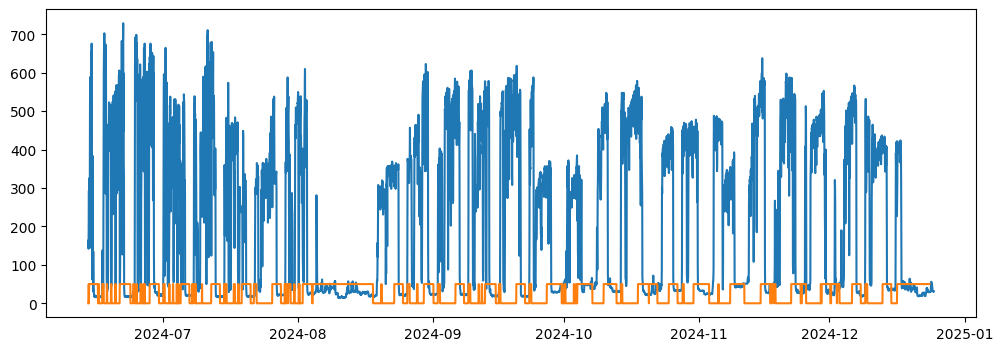

In [36]:
df_vpc_cut['low_load_shifted_24'] = (df_vpc_cut['Load'] < 70).astype(int).shift(-24)
plt.figure(figsize=(12,4))
plt.plot(df_vpc_cut.index, df_vpc_cut['Load'].values)
plt.plot(df_vpc_cut.index, df_vpc_cut['low_load_shifted_24']*50)
plt.show()

In [45]:
df_forecasts_vaf_cut_nooff = df_forecasts.copy()
df_forecasts_vaf_cut_nooff
df_forecasts_vaf_cut_nooff.to_csv("df_forecasts_vaf_cut_nooff244.csv")

In [20]:
df_forecasts_vaf_cut_weloff = df_forecasts.copy()
df_forecasts_vaf_cut_weloff
df_forecasts_vaf_cut_weloff.to_csv("df_forecasts_vaf_cut_weloff214.csv")

In [82]:
# df_forecasts_vpc_cut_nooff = df_forecasts.copy()
df_forecasts_vpc_cut_nooff
df_forecasts_vpc_cut_nooff.to_csv("df_forecasts_vpc_cut_nooff125.csv")

In [78]:
# df_forecasts_vpc_cut_weloff= df_forecasts.copy()
df_forecasts_vpc_cut_weloff.to_csv("df_forecasts_vpc_cut_weloffdayofweek_55.csv")

In [70]:
# df_forecasts_vel_cut = df_forecasts.copy()
df_forecasts_vel_cut
df_forecasts_vel_cut.to_csv("df_forecasts_vel_cut_weloff50_19.2.csv")


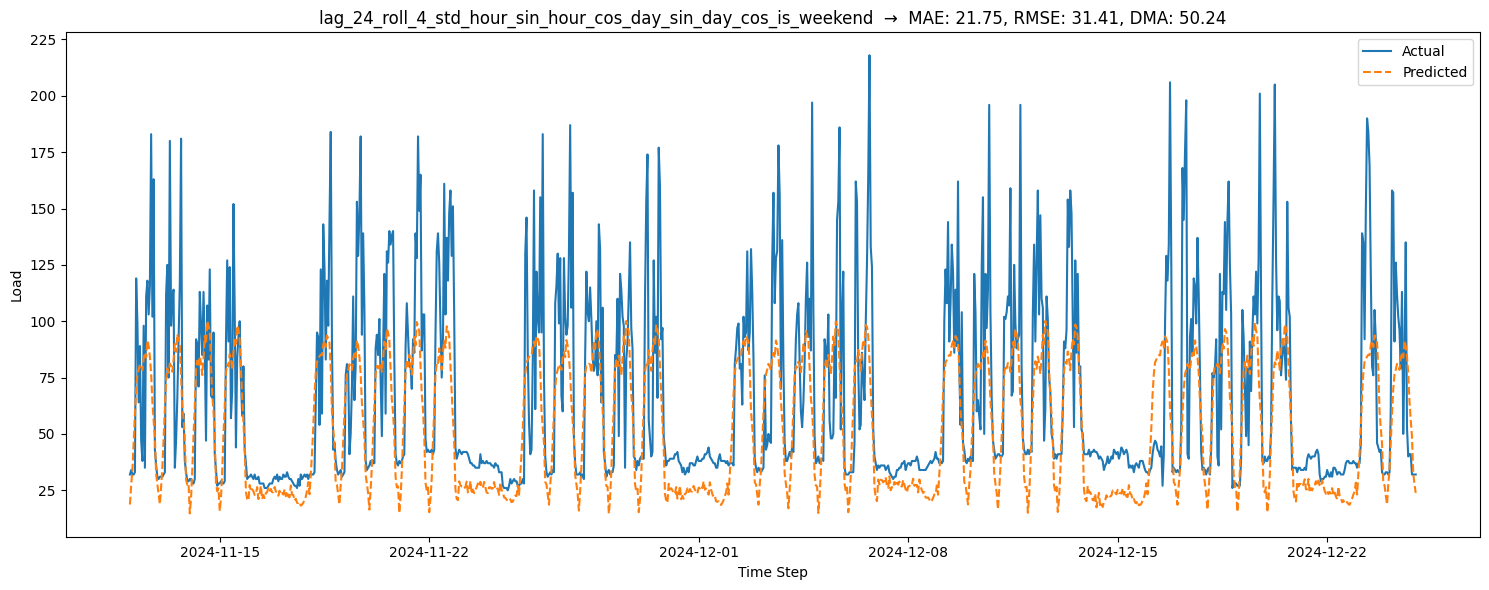

In [30]:
plt.figure(figsize=(15, 6))
plt.plot(df_forecasts.index, df_forecasts['Load_true'], label='Actual')
plt.plot(df_forecasts.index, df_forecasts['Load_pred'], label='Predicted', linestyle='dashed')
plt.title(f"{feat_str}  →  MAE: {mae_real:.2f}, RMSE: {rmse_real:.2f}, DMA: {dma_value:.2f}")
plt.xlabel("Time Step")
plt.ylabel("Load")
plt.legend()
plt.tight_layout()
plot_path_real = os.path.join(PLOTS_DIR, f"plot_{feat_str}_real_1fout.png")
plt.savefig(plot_path_real)
plt.show()


Last forecast made for: 2024-12-23 23:00:00
Last timestamp in dataset: 2024-12-24 00:00:00
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


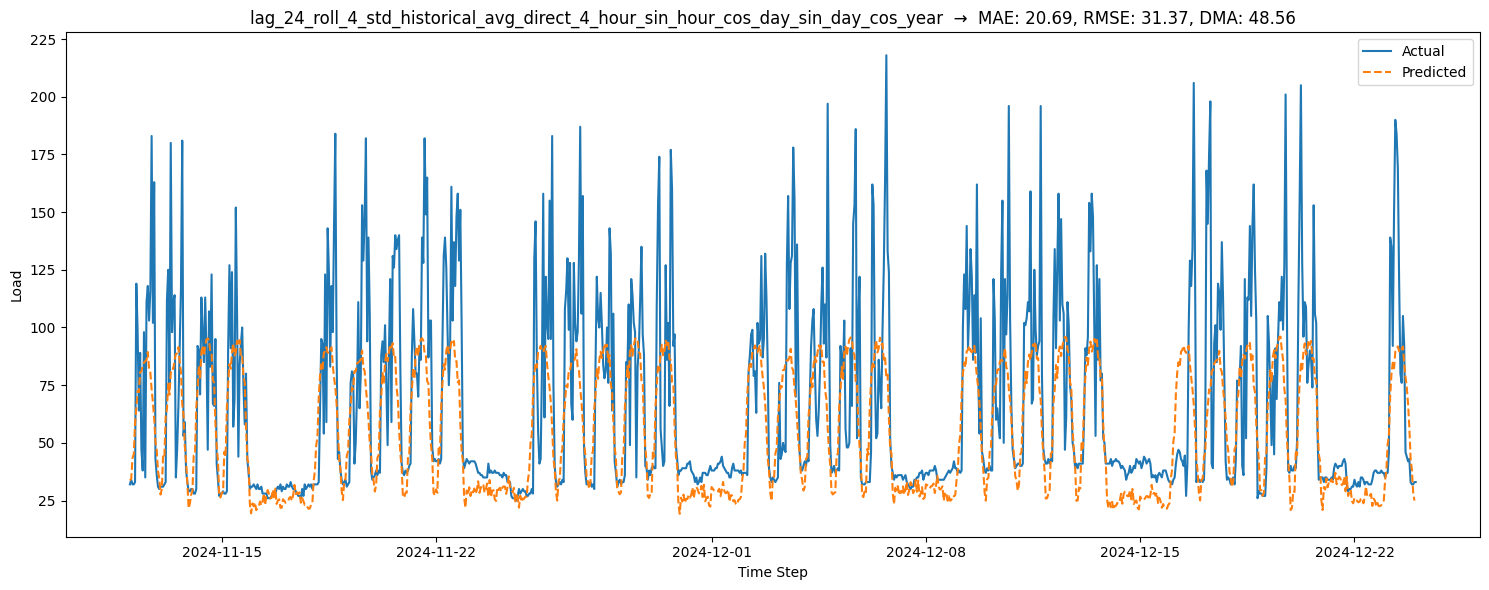

✔ [lag_24_roll_4_std_historical_avg_direct_4_hour_sin_hour_cos_day_sin_day_cos_year] saved model + plot  →  MAE_val: 20.808, RMSE_val: 31.883,  MAE_test: 20.693, RMSE_test: 31.370, DMA: 48.56, DTW: 840.44

All results:
                                            features    MAE_val   RMSE_val  \
0  [lag_24, roll_4_std, historical_avg_direct_4, ...  20.808171  31.883279   

    MAE_test  RMSE_test        DMA         DTW  
0  20.692895  31.369588  48.560079  840.439541  

Best combo: ['lag_24', 'roll_4_std', 'historical_avg_direct_4', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'year']  →  MAE_val: 20.808
hour_sin   -0.000084
dtype: float64 hour_sin    0.707122
dtype: float64
hour_cos    0.000314
dtype: float64 hour_cos    0.707321
dtype: float64
day_sin   -0.010862
dtype: float64 day_sin    0.707833
dtype: float64
day_cos   -0.009068
dtype: float64 day_cos    0.706469
dtype: float64


In [ ]:
 # 24 hour plot (more correct)
X_test, y_test, t0_list = create_sequences_24_hour(test_s, combo, window_size, prediction_time, step=24, return_times=True)
y_pred_scaled_2 = model.predict(X_test)
y_pred        = scaler_y.inverse_transform(y_pred_scaled_2)
y_true        = scaler_y.inverse_transform(y_test)
# Build a DataFrame whose rows are the 24‑h forecasts
records = []
for base_time, truth_row, pred_row in zip(t0_list, y_true, y_pred):
    hourly_index = pd.date_range(start=base_time, periods=24, freq='h')
    records.append(pd.DataFrame({
        'timestamp': hourly_index,
        'Load_true': truth_row,
        'Load_pred': pred_row
    }))
df_forecasts = pd.concat(records).set_index('timestamp')
# Compute evaluation metrics
mae_real = mean_absolute_error(y_true.flatten(), y_pred.flatten())
rmse_real = math.sqrt(mean_squared_error(y_true.flatten(), y_pred.flatten()))
dma_value  = directional_mean_accuracy(y_true.flatten(), y_pred.flatten())
dtw_d = dtw.distance(y_true.flatten(), y_pred.flatten())

# 6) plot Actual vs Predicted
plt.figure(figsize=(15, 6))
plt.plot(test_df.index,test_df['Load'].values, label='Actual')
plt.plot(df_forecasts.index,df_forecasts['Load_pred'], label='Predicted', linestyle='dashed')
plt.title(f"{feat_str}  →  MAE: {mae_real:.2f}, RMSE: {rmse_real:.2f}, DMA: {dma_value:.2f}")
plt.xlabel("Time Step")
plt.ylabel("Load")
plt.legend()
plt.tight_layout()
plot_path_real     = os.path.join(PLOTS_DIR,      f"plot_{feat_str}_real_1fout.png")
plt.savefig(plot_path_real)
plt.show()



# 7) record result
results.append({'features': combo, 'MAE_val': mae, 'RMSE_val': rmse,'MAE_test': mae_real, 'RMSE_test': rmse_real, 'DMA': dma_value, 'DTW': dtw_d })
print(f"✔ [{feat_str}] saved model + plot  →  MAE_val: {mae:.3f}, RMSE_val: {rmse:.3f},  MAE_test: {mae_real:.3f}, RMSE_test: {rmse_real:.3f}, DMA: {dma_value:.2f}, DTW: {dtw_d:.2f}")

# final summary
results_df = pd.DataFrame(results).sort_values('MAE_val').reset_index(drop=True)
print("\nAll results:")
print(results_df)

best = results_df.iloc[0]
print(f"\nBest combo: {best['features']}  →  MAE_val: {best['MAE_val']:.3f}")

for i in features_pass:
  print(train_s[[i]].mean(), train_s[[i]].std())


Please upload the forecast CSVs for VAF, VEL, and VPC:


Saving df_forecasts_vaf_cut_weloff214.csv to df_forecasts_vaf_cut_weloff214 (1).csv
Saving df_forecasts_vpc_cut_weloff50.csv to df_forecasts_vpc_cut_weloff50.csv
Saving df_forecasts_vel_cut_weloff50_19.2 (1).csv to df_forecasts_vel_cut_weloff50_19.2 (1) (1).csv

MAE:  237.165
RMSE: 292.568
DMA:  52.76%
DTW:  7036.965


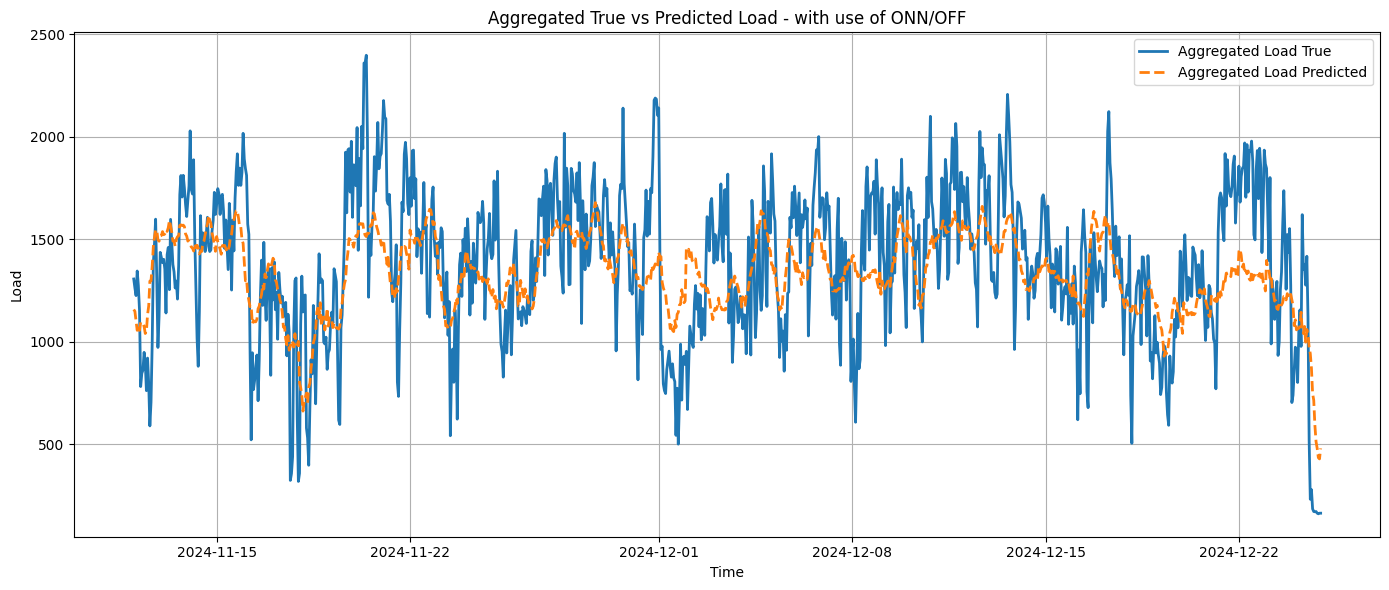

In [7]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from dtaidistance import dtw
from google.colab import files
import io

# === Upload Files ===
print("Please upload the forecast CSVs for VAF, VEL, and VPC:")
uploaded = files.upload()

# === Directional Mean Accuracy ===
def directional_mean_accuracy(actual, pred):
    actual = np.array(actual)
    pred = np.array(pred)
    actual_direction = np.sign(actual[1:] - actual[:-1])
    pred_direction = np.sign(pred[1:] - pred[:-1])
    correct_direction = (actual_direction == pred_direction)
    return np.mean(correct_direction) * 100

# === Identify and load data ===
dfs = {}
for fname in uploaded.keys():
    content = io.BytesIO(uploaded[fname])
    df = pd.read_csv(content, parse_dates=[0], index_col=0)

    name = fname.lower()
    if "vaf" in name:
        dfs['vaf'] = df
    elif "vel" in name:
        dfs['vel'] = df
    elif "vpc" in name:
        dfs['vpc'] = df
    else:
        print(f"Skipped unknown file: {fname}")

# === Validate ===
if len(dfs) != 3:
    raise ValueError("Make sure all three files (VAF, VEL, VPC) are uploaded and correctly named.")

# === Aggregate ===
idx = dfs['vaf'].index
df_combined = pd.DataFrame(index=idx)
df_combined['Load_true'] = dfs['vaf']['Load_true'] + dfs['vel']['Load_true'] + dfs['vpc']['Load_true']
df_combined['Load_pred'] = dfs['vaf']['Load_pred'] + dfs['vel']['Load_pred'] + dfs['vpc']['Load_pred']

# === Metrics ===
y_true = df_combined['Load_true'].values
y_pred = df_combined['Load_pred'].values

mae_real = mean_absolute_error(y_true, y_pred)
rmse_real = math.sqrt(mean_squared_error(y_true, y_pred))
dma_value = directional_mean_accuracy(y_true, y_pred)
dtw_d = dtw.distance(y_true, y_pred)

# === Results ===
print(f"\nMAE:  {mae_real:.3f}")
print(f"RMSE: {rmse_real:.3f}")
print(f"DMA:  {dma_value:.2f}%")
print(f"DTW:  {dtw_d:.3f}")

# === Plot ===
plt.figure(figsize=(14, 6))
plt.plot(df_combined.index, df_combined['Load_true'], label='Aggregated Load True', linewidth=2)
plt.plot(df_combined.index, df_combined['Load_pred'], label='Aggregated Load Predicted', linestyle='--', linewidth=2)
plt.title('Aggregated True vs Predicted Load - with use of ONN/OFF')
plt.xlabel('Time')
plt.ylabel('Load')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [8]:
from google.colab import files
import io
import pandas as pd

# 1) Upload any files
print("Upload your full_features CSV and/or Excel:")
uploaded = files.upload()

# 2) Load the ones that have “full_features” in their filename
df_csv = None
df_xlsx = None

for fname, content in uploaded.items():
    lname = fname.lower()
    if "full_features" in lname:
        if lname.endswith(".csv"):
            df_csv = pd.read_csv(
                io.BytesIO(content),
                index_col=0,
                parse_dates=True
            )
            print(f"Loaded CSV into df_csv from {fname}")
        elif lname.endswith((".xls", ".xlsx")):
            df_xlsx = pd.read_excel(
                io.BytesIO(content),
                sheet_name=0,
                index_col=0,
                parse_dates=True
            )
            print(f"Loaded Excel into df_xlsx from {fname}")

# 3) Now df_csv and/or df_xlsx hold your DataFrame(s)
# Example check:
if df_csv is not None:
    print("CSV shape:", df_csv.shape)
    display(df_csv.head())
if df_xlsx is not None:
    print("Excel shape:", df_xlsx.shape)
    display(df_xlsx.head())



Upload your full_features CSV and/or Excel:


Saving full_features (7).csv to full_features (7).csv
Loaded CSV into df_csv from full_features (7).csv
CSV shape: (17040, 74)


,Load,hour,Day_of_week,Day_of_year,month,year,week_of_year,season,is_weekend,hour_sin,...,Exogenous_5_shifted_48,Exogenous_3_shifted_24,Exogenous_4_shifted_24,Exogenous_5_shifted_24,Relation_Hour_Weekday,shift_1,shift_2,temperature,temperature_lag48,temperature_lag54
datetime,,,,,,,,,,,,,,,,,,,,,
2023-01-15 00:00:00,1372.0,0,6,15,1,2023,2,2,1,0.000000,...,0.0,0.0,0.0,0.0,2,0,1,NaN,NaN,NaN
2023-01-15 01:00:00,1520.0,1,6,15,1,2023,2,2,1,0.258819,...,0.0,0.0,0.0,0.0,2,0,1,NaN,NaN,NaN
2023-01-15 02:00:00,1472.0,2,6,15,1,2023,2,2,1,0.500000,...,0.0,0.0,0.0,0.0,2,0,1,NaN,NaN,NaN
2023-01-15 03:00:00,1408.0,3,6,15,1,2023,2,2,1,0.707107,...,0.0,0.0,0.0,0.0,2,0,1,NaN,NaN,NaN
2023-01-15 04:00:00,1502.0,4,6,15,1,2023,2,2,1,0.866025,...,0.0,0.0,0.0,0.0,2,0,1,NaN,NaN,NaN


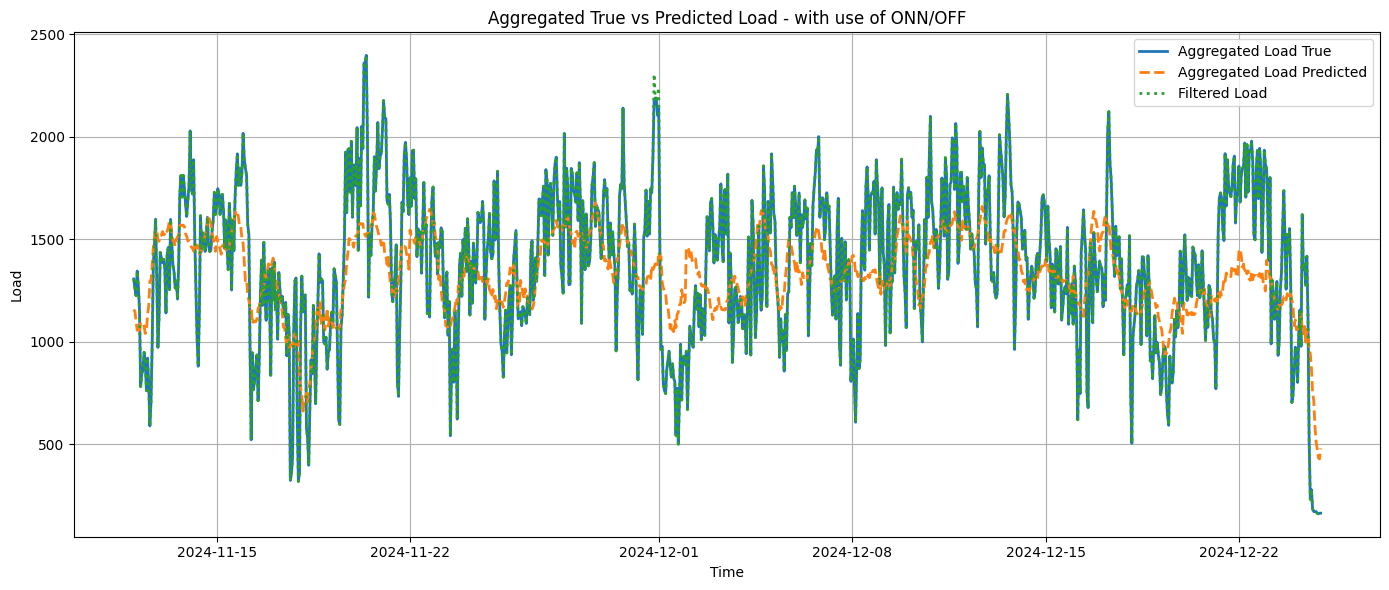

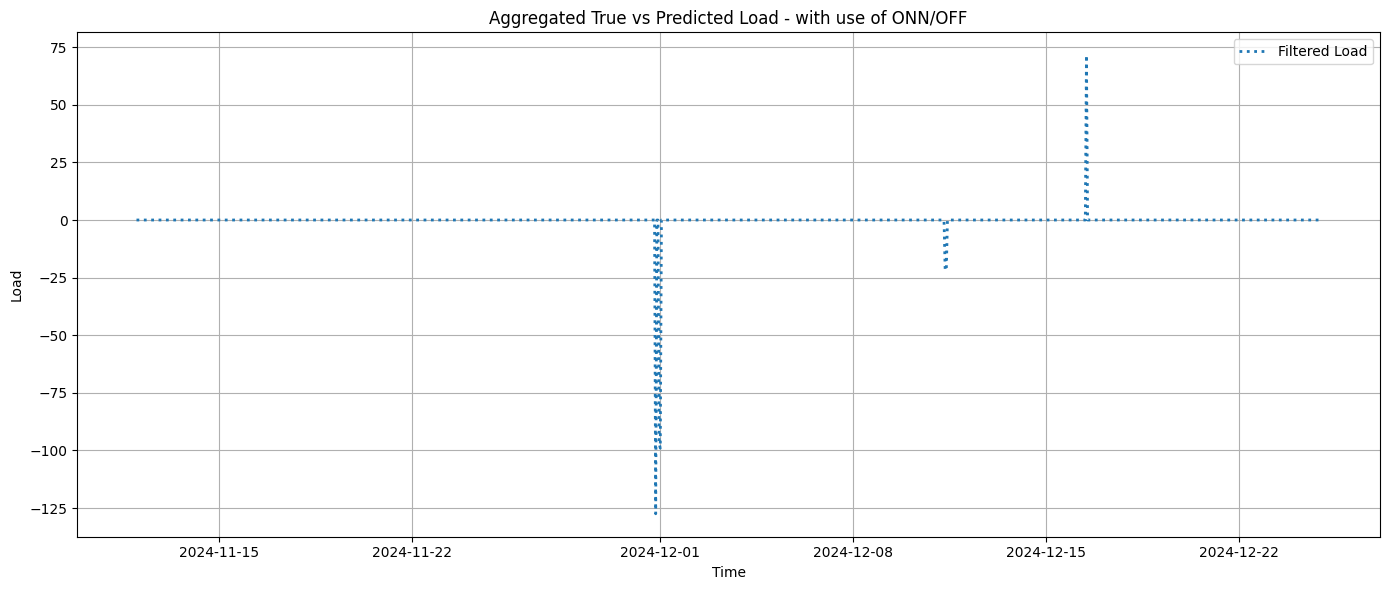


MAE:  237.409
RMSE: 293.428
DMA:  52.57%
DTW:  7064.900


In [12]:
df_filtered = df_csv.loc[df_combined.index]
plt.figure(figsize=(14, 6))
plt.plot(df_combined.index, df_combined['Load_true'], label='Aggregated Load True', linewidth=2)
plt.plot(df_combined.index, df_combined['Load_pred'], label='Aggregated Load Predicted', linestyle='--', linewidth=2)
plt.plot(df_filtered.index, df_filtered['Load'], label='Filtered Load', linestyle='dotted', linewidth=2)
plt.title('Aggregated True vs Predicted Load - with use of ONN/OFF')
plt.xlabel('Time')
plt.ylabel('Load')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


plt.figure(figsize=(14, 6))
plt.plot(df_combined.index, df_combined['Load_true']- df_filtered['Load'], label='Filtered Load', linestyle='dotted', linewidth=2)
plt.title('Aggregated True vs Predicted Load - with use of ONN/OFF')
plt.xlabel('Time')
plt.ylabel('Load')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

y_true = df_filtered['Load'].values
y_pred = df_combined['Load_pred'].values

mae_real = mean_absolute_error(y_true, y_pred)
rmse_real = math.sqrt(mean_squared_error(y_true, y_pred))
dma_value = directional_mean_accuracy(y_true, y_pred)
dtw_d = dtw.distance(y_true, y_pred)

# === Results ===
print(f"\nMAE:  {mae_real:.3f}")
print(f"RMSE: {rmse_real:.3f}")
print(f"DMA:  {dma_value:.2f}%")
print(f"DTW:  {dtw_d:.3f}")



XGBOOST


In [12]:
column_list = df_cvs_VPC.columns.tolist()
print(column_list)

['Load', 'hour', 'Day_of_week', 'Day_of_year', 'month', 'year', 'week_of_year', 'season', 'is_weekend', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'Holidays', 'roll_168_std', 'historical_avg_168', 'roll_120_std', 'historical_avg_120', 'roll_48_std', 'historical_avg_48', 'roll_24_std', 'historical_avg_24', 'roll_12_std', 'historical_avg_12', 'roll_4_std', 'historical_avg_4', 'roll_168_std_direct', 'historical_avg_direct_168', 'roll_120_std_direct', 'historical_avg_direct_120', 'roll_48_std_direct', 'historical_avg_direct_48', 'roll_24_std_direct', 'historical_avg_direct_24', 'roll_12_std_direct', 'historical_avg_direct_12', 'roll_4_std_direct', 'historical_avg_direct_4', 'roll_24_mean', 'roll_4_mean', 'lag_24', 'lag_48', 'lag_144', 'lag_168', 'lag_312', 'lag_336', 'trend_last4h', 'avg_last4h', 'trend_last24h', 'avg_last24h', 'trend_last48h', 'avg_last48h', 'dow_0', 'dow_1', 'dow_2', 'dow_3', 'dow_4', 'dow_5', 'dow_6', 'Exogenous_3', 'Exogenous_4', 'Exogenous_5', 'Exogenous_3_shifted_

In [19]:
all_features = [ 'hour', 'Day_of_week', 'Day_of_year', 'month', 'year', 'week_of_year', 'season',
                'is_weekend', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'Holidays', 'roll_168_std', 'historical_avg_168',
                'roll_120_std', 'historical_avg_120', 'roll_48_std', 'historical_avg_48', 'roll_24_std', 'historical_avg_24',
                'roll_12_std', 'historical_avg_12', 'roll_4_std', 'historical_avg_4', 'roll_168_std_direct', 'historical_avg_direct_168',
                'roll_120_std_direct', 'historical_avg_direct_120', 'roll_48_std_direct', 'historical_avg_direct_48', 'roll_24_std_direct',
                'historical_avg_direct_24', 'roll_12_std_direct', 'historical_avg_direct_12', 'roll_4_std_direct', 'historical_avg_direct_4',
                'roll_24_mean', 'roll_4_mean', 'lag_24', 'lag_48', 'lag_144', 'lag_168', 'lag_312', 'lag_336', 'trend_last4h', 'avg_last4h',
                'trend_last24h', 'avg_last24h', 'trend_last48h', 'avg_last48h', 'dow_0', 'dow_1', 'dow_2', 'dow_3', 'dow_4', 'dow_5', 'dow_6',
                'Exogenous_3', 'Exogenous_4', 'Exogenous_5', 'Exogenous_3_shifted_48', 'Exogenous_4_shifted_48', 'Exogenous_5_shifted_48',
                'Exogenous_3_shifted_24', 'Exogenous_4_shifted_24', 'Exogenous_5_shifted_24', 'Relation_Hour_Weekday', 'shift_1', 'shift_2',
                'temperature', 'temperature_lag48', 'temperature_lag54']

TARGET = 'Load'


Testing combo 1 of 1


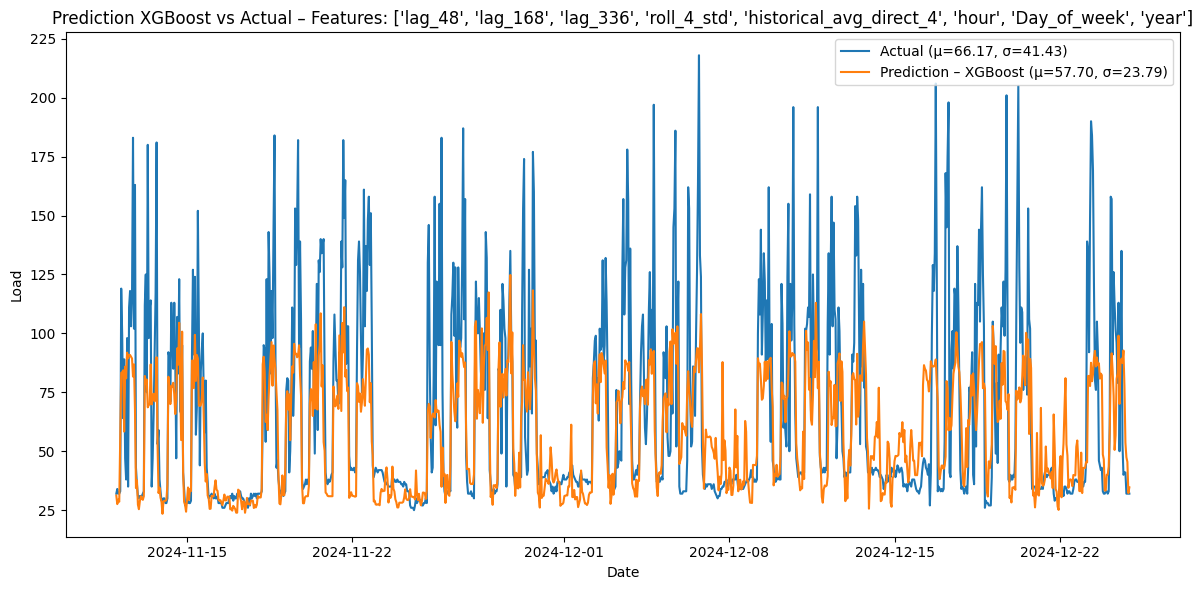

✅ Saved results to results_lag_48_lag_168_lag_336_roll_4_std_historical_avg_direct_4_hour_Day_of_week_year.csv
✅ Saved results to results_lag_48_lag_168_lag_336_roll_4_std_historical_avg_direct_4_hour_Day_of_week_year.xlsx


,features_used,mae,rmse,mape,dma,dtw
0,"[lag_48, lag_168, lag_336, roll_4_std, histori...",19.66,30.32,27.154587,48.302619,779.565604


In [20]:
data_short = df_vel_cut

# Define cut‑over dates (same logic as before)
val_start  = pd.to_datetime("2024-10-20")
test_start = pd.to_datetime("2024-11-12")

# 1st split: train vs. val+test
split_date = val_start  # equivalent to "2024-10-20"
load_train_f = data_short[data_short.index < split_date]
load_test_f  = data_short[data_short.index >= split_date]

# 2nd split: val vs. test (from what's currently in load_test_f)
split_date_2 = test_start  # equivalent to "2024-11-12"
load_val_f   = load_test_f[load_test_f.index < split_date_2]
load_test_f  = load_test_f[load_test_f.index >= split_date_2]



import numpy as np

def mean_absolute_percentage_error(actual, pred):
    actual = np.array(actual)
    pred   = np.array(pred)
    # Calculate MAPE (%) – add a small epsilon to avoid division by zero if needed
    return np.mean(np.abs((actual - pred) / (actual + 1e-8))) * 100

def directional_mean_accuracy(actual, pred):
    actual = np.array(actual)
    pred   = np.array(pred)
    # Calculate the sign of changes for actual and predicted
    actual_direction = np.sign(actual[1:] - actual[:-1])
    pred_direction   = np.sign(pred[1:] - pred[:-1])
    # Compare directions and compute accuracy as a percentage
    correct_direction = (actual_direction == pred_direction)
    return np.mean(correct_direction) * 100

# # Define training & testing data

X_train = load_train_f[all_features]
Y_train = load_train_f[TARGET]
X_val = load_val_f[all_features]
Y_val = load_val_f[TARGET]
X_test = load_test_f[all_features]
Y_test = load_test_f[TARGET]

import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import numpy as np
import shap

X = data_short[all_features]          # full feature matrix
y = data_short[TARGET]                # full target series

tscv = TimeSeriesSplit(n_splits=5)    # 5-fold expanding window
results = []


test_combinations = [['lag_48', 'lag_168', 'lag_336', 'roll_4_std', 'historical_avg_direct_4', 'hour', 'Day_of_week', 'year']]



import plotly.graph_objects as go
from dtaidistance import dtw




# Results storage
results = []
i = 0
for combo in test_combinations:
    i += 1
    print(f"Testing combo {i} of {len(test_combinations)}")
    try:
        model = xgb.XGBRegressor(
            n_estimators=3000,
            learning_rate=0.001,
            objective='reg:squarederror',
            early_stopping_rounds=40,
            verbosity=0
        )

        model.fit(
            X_train[combo], Y_train,
            eval_set=[(X_val[combo], Y_val)],
            verbose=False
        )

        preds = model.predict(X_test[combo])
        mae = mean_absolute_error(Y_test, preds)
        rmse = np.sqrt(mean_squared_error(Y_test, preds))
                # Example usage:
        mape_value = mean_absolute_percentage_error(Y_test, preds)
        dma_value  = directional_mean_accuracy(Y_test, preds)
        dtw_d = dtw.distance(Y_test.values.astype(float), preds.astype(float))
        # print(f"MAPE: {mape_value:.2f}%")
        # print(f"DMA:  {dma_value:.2f}%")

        results.append({
            "features_used": combo,
            "mae": round(mae, 2),
            "rmse": round(rmse, 2),
            "mape": mape_value,
            "dma": dma_value,
            "dtw": dtw_d
        })

        # # 3) SHAP analysis
        # explainer   = shap.TreeExplainer(model)
        # shap_vals   = explainer.shap_values(X_train[combo])

        # # a) SHAP bar plot
        # plt.figure(figsize=(6,4))
        # shap.summary_plot(shap_vals, X_train[combo], plot_type='bar', show=False)
        # plt.title(f"SHAP Importance (bar)\n{combo}")
        # plt.tight_layout()
        # plt.show()

        # # b) SHAP beeswarm
        # plt.figure(figsize=(6,4))
        # shap.summary_plot(shap_vals, X_train[combo], show=False)
        # plt.title(f"SHAP Beeswarm\n{combo}")
        # plt.tight_layout()
        # plt.show()

        # # c) XGBoost gain importance
        # plt.figure(figsize=(6,4))
        # xgb.plot_importance(model, importance_type='gain', max_num_features=10, show=False)
        # plt.title(f"XGB Gain Importance\n{combo}")
        # plt.tight_layout()
        # plt.show()

        # Compute error and rolling error if needed
        error = Y_test - preds
        abs_error = error.abs()
        rolling_error = error.rolling(49, center=True).mean()

                # Compute statistics
        actual_mean = Y_test.mean()
        actual_std  = Y_test.std()
        preds_mean  = preds.mean()
        preds_std   = preds.std()

        # # # --- Using Plotly for interactive plotting ---
        # fig = go.Figure()

        # # Add actual load trace
        # fig.add_trace(go.Scatter(
        #     x=Y_test.index,
        #     y=Y_test.values,
        #     mode='lines',
        #     name='Actual',
        #     line=dict(color='blue')
        # ))

        # # Add prediction trace
        # fig.add_trace(go.Scatter(
        #     x=Y_test.index,
        #     y=preds,
        #     mode='lines',
        #     name='Prediction',
        #     line=dict(color='orange')
        # ))

        # fig.update_layout(
        #     title=f"Prediction vs Actual - Features: {combo}",
        #     xaxis_title="Date",
        #     yaxis_title="Load",
        #     hovermode="x unified"
        # )

        # fig.show()
        # --- Standard Matplotlib plot ---
        plt.figure(figsize=(12, 6))
        plt.plot(Y_test.index, Y_test.values, label=f"Actual (μ={actual_mean:.2f}, σ={actual_std:.2f})")
        plt.plot(Y_test.index, preds,       label=f"Prediction – XGBoost (μ={preds_mean:.2f}, σ={preds_std:.2f})")
        plt.title(f"Prediction XGBoost vs Actual – Features: {combo}")
        plt.xlabel("Date")
        plt.ylabel("Load")
        plt.legend(loc='upper right')
        plt.tight_layout()
        plt.show()

        # --- Build results DataFrame ---
        df_results = pd.DataFrame({
            'Actual':     Y_test.values,
            'Prediction': preds
        }, index=Y_test.index)

        # --- Save to disk ---
        # CSV (easiest to inspect/edit in Python or Excel):
        csv_path = f"results_{'_'.join(combo)}.csv"
        df_results.to_csv(csv_path)
        print(f"✅ Saved results to {csv_path}")

        # Excel (if you need multiple sheets later):
        excel_path = f"results_{'_'.join(combo)}.xlsx"
        df_results.to_excel(excel_path, sheet_name='Pred_vs_Actual')
        print(f"✅ Saved results to {excel_path}")


    except Exception as e:
        results.append({
            "features_used": combo,
            "mae": None,
            "rmse": None,
            "error": str(e)
        })

# Display results as DataFrame and save to Excel if needed
results_df_new = pd.DataFrame(results)
results_df_new.to_excel("my_output.xlsx", index=False)
results_df_new


